<div class="alert alert-info"> <b>прикладываю сразу черновые варианты:</b>

* [Презентация](https://disk.yandex.ru/i/L24BUnTJ1UbxAQ)
* [Дашборд](https://public.tableau.com/app/profile/senyanordwest/viz/final_dashb_punenko_da35/Dashboard1?publish=yes)





 <font size=5><font color='darkslateblue'>
<b>Анализ оттока клиентов банка</b></font>

<font size=4><b>Задача</b></font><br/>
Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.<br/>

## Описание исходных данных

Исходные данные банком предоставлены в csv-файле (датасет <i>bank_dataset.csv</i>). Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.<br/>

                                                Описание данных в датасете:
|  	|  	|
|:---	|:---	|
|`userid`|  идентификатор пользователя|
|`score`|  баллы кредитного скоринга|
|`City`|  город|
|`Gender`|  пол|
|`Age`|  возраст|
|`Objects`|  количество объектов в собственности|
|`Balance`|  баланс на счёте|
|`Products`|  количество продуктов, которыми пользуется клиент|
|`CreditCard`|  есть ли кредитная карта|
|`Loyalty`|  активный клиент|
|`estimated_salary`|  заработная плата клиента|
|`Churn`|  ушёл или нет|

## Загрузка и предобработка данных

In [1]:
#импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.cluster import hierarchy

import math as mth
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

sns.set(font_scale=1.1)
#sns.set_style("darkgrid", {"grid.color": "dimgray", "grid.linestyle": ":"})
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  

In [2]:
# загружаем исходные данные
bank_data = pd.read_csv('/datasets/bank_dataset.csv')


def first_look(df):
    """ функция для "первого взгляда на данные"
    """
    print('\033[1m' + 'Общая информация о датасете:' + '\033[0m')
    df.info(),
    (df.style.set_properties(
    **{'text-align': 'center'}).highlight_null(null_color='lightcoral')),
    print('~'*10*5),
    print('\033[1m' + 'Количество пропусков в столбцах:' + '\033[0m'),
    print(df.isna().sum()),
    print('~'*10*5),
    print('Количество дублей:', df.duplicated().sum())
    return df.sample(10, random_state=1)

first_look(bank_data)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Количество пропусков в столбцах:
userid                 0
score                  0
City   

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9953,15698688,550,Ярославль,М,47,2,NaN,2,1,1,"97,057.28",0
3850,15818029,680,Ярославль,М,34,3,"143,292.95",1,1,0,"66,526.01",0
4962,15707824,531,Ярославль,Ж,42,2,NaN,2,0,1,"90,537.47",0
3886,15763677,710,Ростов Великий,М,34,8,"147,833.30",2,0,1,"1,561.58",0
5437,15776212,543,Ростов Великий,М,30,6,"73,481.05",1,1,1,"176,692.65",0
8517,15714536,688,Ярославль,М,20,8,"137,624.40",2,1,1,"197,582.79",0
2041,15752582,840,Ярославль,Ж,39,1,"94,968.97",1,1,0,"84,487.62",0
1989,15665190,695,Рыбинск,М,28,0,"96,020.86",1,1,1,"57,992.49",0
1933,15858296,666,Ростов Великий,М,74,7,"105,102.50",1,1,1,"46,172.47",0
9984,15738911,602,Ростов Великий,М,35,7,"90,602.42",2,1,1,"51,695.41",0


<font size=2,5>
    
* Располагаем данными о 10000 клиентов банка, явных дубликатов нет.
* C типами данных по столбцам всё в порядке, пропущенные значения есть только в столбце `Balance` - баланс на счёте, пропусков довольно много, в дальнейшем стоит определить как стоит с ними поступить.
* Стоит также поправить названия столбцов в <i>snake_case</i>.
* А для столбцов `City` и `Gender` категоральные значения заменить на числовые, это в дальнейшем пригодится для кластеризации клиентов.

In [3]:
# переводим названия столбцов в нижний регистр
bank_data.columns = map(str.lower, bank_data.columns)

In [4]:
# переименовываем столбцы
bank_data = bank_data.rename(columns={"userid":"user_id", "creditcard":"credit_card"})
bank_data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


In [5]:
bank_data.query('churn == 1')

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
5,15616748,645,Рыбинск,М,44,8,"113,755.78",2,1,0,"149,756.71",1
7,15698884,376,Ростов Великий,Ж,29,4,"115,046.74",4,1,0,"119,346.88",1
16,15780188,653,Ростов Великий,М,58,1,"132,602.88",1,1,0,"5,097.67",1
...,...,...,...,...,...,...,...,...,...,...,...,...
9981,15715490,498,Ростов Великий,М,42,3,"152,039.70",1,1,1,"53,445.17",1
9982,15810899,655,Ростов Великий,Ж,46,7,"137,145.12",1,1,0,"115,146.40",1
9991,15812695,597,Ярославль,Ж,53,4,"88,381.21",1,1,0,"69,384.71",1
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,"42,085.58",1


<font size=2,5> Поменяем значения в столбцах `gender` и `city`. Столбец с полом биноминальный, значения поменяем с помощью LabelEncoder() из модуля sklearn.preprocessing, а названия городов поменяем на dummy-переменные:

In [6]:
# gender
encoder =  LabelEncoder()
bank_data['gender'] = encoder.fit_transform(bank_data['gender'])

# city
bank_data = pd.get_dummies(bank_data)
bank_data.head()

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,0,42,2,NaN,1,1,1,"101,348.88",1,0,0,1
1,15690047,608,0,41,1,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,15662040,502,0,42,8,"159,660.80",3,1,0,"113,931.57",1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,"93,826.63",0,0,0,1
4,15780624,850,0,43,2,"125,510.82",1,1,1,"79,084.10",0,0,1,0


<font size=2,5> Также немного поменяем последовательность столбцов - сгруппируем вместе бинарные признаки, визуально сделаем таблицу немного более удобной.

Дашборд & презентация

In [7]:
bank_data.columns.tolist()

['user_id',
 'score',
 'gender',
 'age',
 'objects',
 'balance',
 'products',
 'credit_card',
 'loyalty',
 'estimated_salary',
 'churn',
 'city_Ростов Великий',
 'city_Рыбинск',
 'city_Ярославль']

In [8]:
bank_data = bank_data[['user_id', 'score', 'age', 'objects', 'balance', 'products', 'estimated_salary',
                       'churn', 'gender', 'credit_card', 'loyalty', 
                       'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль']]
bank_data.head(5)

,user_id,score,age,objects,balance,products,estimated_salary,churn,gender,credit_card,loyalty,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,42,2,NaN,1,"101,348.88",1,0,1,1,0,0,1
1,15690047,608,41,1,"83,807.86",1,"112,542.58",0,0,0,1,0,1,0
2,15662040,502,42,8,"159,660.80",3,"113,931.57",1,0,1,0,0,0,1
3,15744090,699,39,1,NaN,2,"93,826.63",0,0,0,0,0,0,1
4,15780624,850,43,2,"125,510.82",1,"79,084.10",0,0,1,1,0,1,0


### пропуски в столбце `balance`

In [9]:
print("Процент пропущенных значений в столбце balance: {:.2%}".format(bank_data['balance'].isna().sum()
                                                                      / bank_data['user_id'].count()))

Процент пропущенных значений в столбце balance: 36.17%


<font size=2,5> В столбце с балансом больше чем у трети клиентов отсутствует информация о балансе на счёте, выделим этих клиентов в отдельный датасет и попробуем посмотреть на распределение признаков только по этим клиентам:

In [10]:
nan_balance = bank_data[bank_data['balance'].isna()]
nan_balance.describe().T.style.set_properties(
    **{'text-align': 'center'}).highlight_null(null_color='#FF9999').highlight_min(color='#FFD770', axis=1).highlight_max(color='#D1FFD7', axis=1)

,count,mean,std,min,25%,50%,75%,max
user_id,3617.000000,15734685.585292,71947.494611,15608442.000000,15672255.000000,15736083.000000,15796286.000000,15858100.000000
score,3617.000000,649.452861,96.158798,350.000000,583.000000,651.000000,717.000000,850.000000
age,3617.000000,38.434891,10.492002,18.000000,31.000000,37.000000,43.000000,88.000000
objects,3617.000000,5.071330,2.860781,0.000000,3.000000,5.000000,7.000000,10.000000
balance,0.000000,nan,nan,nan,nan,nan,nan,nan
products,3617.000000,1.784628,0.496455,1.000000,1.000000,2.000000,2.000000,4.000000
estimated_salary,3617.000000,98983.559549,57730.828955,90.070000,49506.820000,98618.790000,148330.970000,199992.480000
churn,3617.000000,0.138236,0.345195,0.000000,0.000000,0.000000,0.000000,1.000000
gender,3617.000000,0.542715,0.498241,0.000000,0.000000,1.000000,1.000000,1.000000
credit_card,3617.000000,0.716616,0.450704,0.000000,0.000000,1.000000,1.000000,1.000000


<font size=2,5> В целом в значениях признаков для клиентов без баланса нет каких-то особенностей, перекосов в сторону минимальных или максимальных значений не наблюдается, можно только отметить, что среди таких клиентов нет жителей из г. Ростов Великий и такие клиенты не склонны к оттоку, среднее значение в столбце `churn` - 0.14.<br/>
Скорее всего мы имеем дело с какой-то технической ошибкой, стоит об этом сообщить специалистам/коллегам, ответственным за подготовку данных.<br/>
    
Заполнение такого большого количества пропусков как нулевыми, так и средними/медианными значениями в любом случае приведёт к искажению дальнейших результатов анализа, поэтому заменим пропущенные значения фиктивной переменной <b><i>-1</i></b>.

In [11]:
bank_data['balance'].fillna(-1, inplace=True)
bank_data.head()

,user_id,score,age,objects,balance,products,estimated_salary,churn,gender,credit_card,loyalty,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,42,2,-1.00,1,"101,348.88",1,0,1,1,0,0,1
1,15690047,608,41,1,"83,807.86",1,"112,542.58",0,0,0,1,0,1,0
2,15662040,502,42,8,"159,660.80",3,"113,931.57",1,0,1,0,0,0,1
3,15744090,699,39,1,-1.00,2,"93,826.63",0,0,0,0,0,0,1
4,15780624,850,43,2,"125,510.82",1,"79,084.10",0,0,1,1,0,1,0


<font size=2,5> <b>Вывод</b><br/>
Данные для анализа подготовлены, исправили названия столбцов, заполнили пропуски в столбце с данными о балансе на счёте, также заменили категоральные значения в столбцах с информацией о <i>поле</i> и <i>городе</i> на числовые, в дальнейшем это упростит кластеризацию клиентов банка.

## Исследовательский анализ данных (EDA)

<font size=2,5>Посмотрим теперь на значения по всему датасету, а не только по клиентам без баланса:

In [12]:
bank_data.describe().T.style.set_properties(
    **{'text-align': 'center'}).highlight_null(null_color='#FF9999').highlight_min(color='#FFD770', axis=1).highlight_max(color='#D1FFD7', axis=1)

,count,mean,std,min,25%,50%,75%,max
user_id,10000.000000,15733676.569400,71936.186123,15608437.000000,15671264.250000,15733474.000000,15795969.750000,15858426.000000
score,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
objects,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
balance,10000.000000,76485.527588,62397.848614,-1.000000,-1.000000,97198.540000,127644.240000,250898.090000
products,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
estimated_salary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000
churn,10000.000000,0.203700,0.402769,0.000000,0.000000,0.000000,0.000000,1.000000
gender,10000.000000,0.545700,0.497932,0.000000,0.000000,1.000000,1.000000,1.000000
credit_card,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000


<font size=2,5> В целом как по численным признакам, так  и по бинарным нет сильных перекосов в данных, средние значения и медианы близки, за исключением значений баланса, т.к. там влияние оказывает фиктивная переменная и также немного подозрительно выглядит минимальное значение заработной платы. Посмотрим на распределение этих значений подробнее:

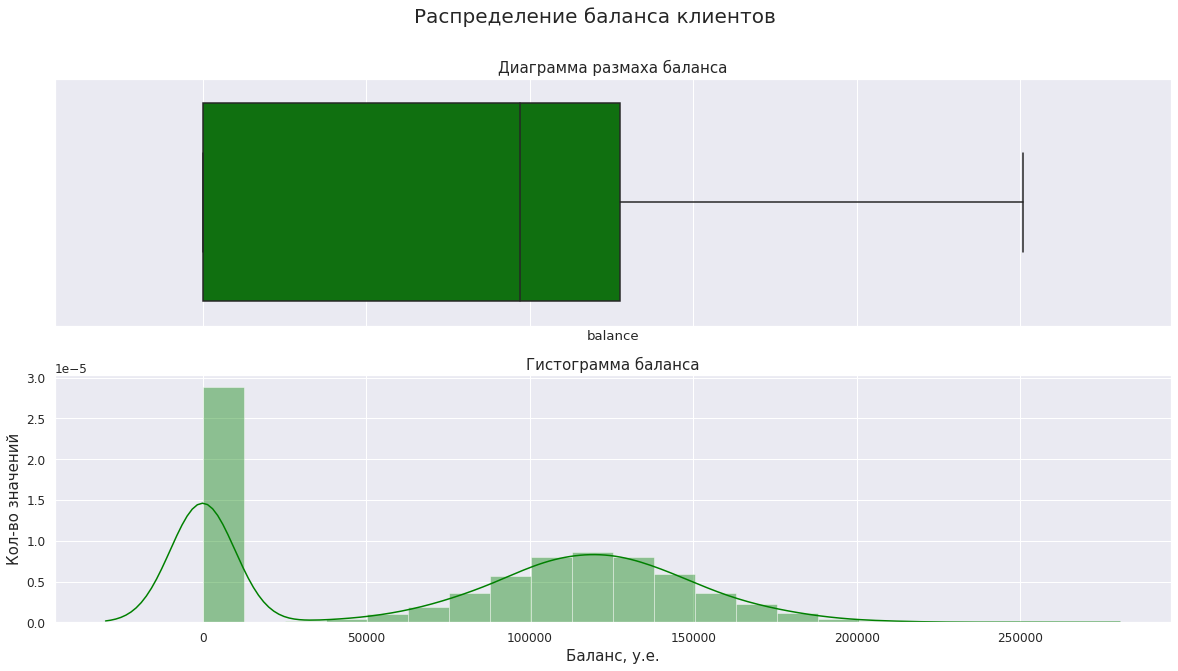

In [13]:
# баланс
f, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))

ax[0].set_title('Диаграмма размаха баланса', size=15)
ax[1].set_title('Гистограмма баланса', size=15)

sns.boxplot(bank_data['balance'], color='green', ax=ax[0])
sns.distplot(bank_data['balance'], bins=20, color='green', ax=ax[1])

plt.xlabel('Баланс, у.е.', size=15)
plt.ylabel('Кол-во значений', size=15)
plt.suptitle("Распределение баланса клиентов", size=20);

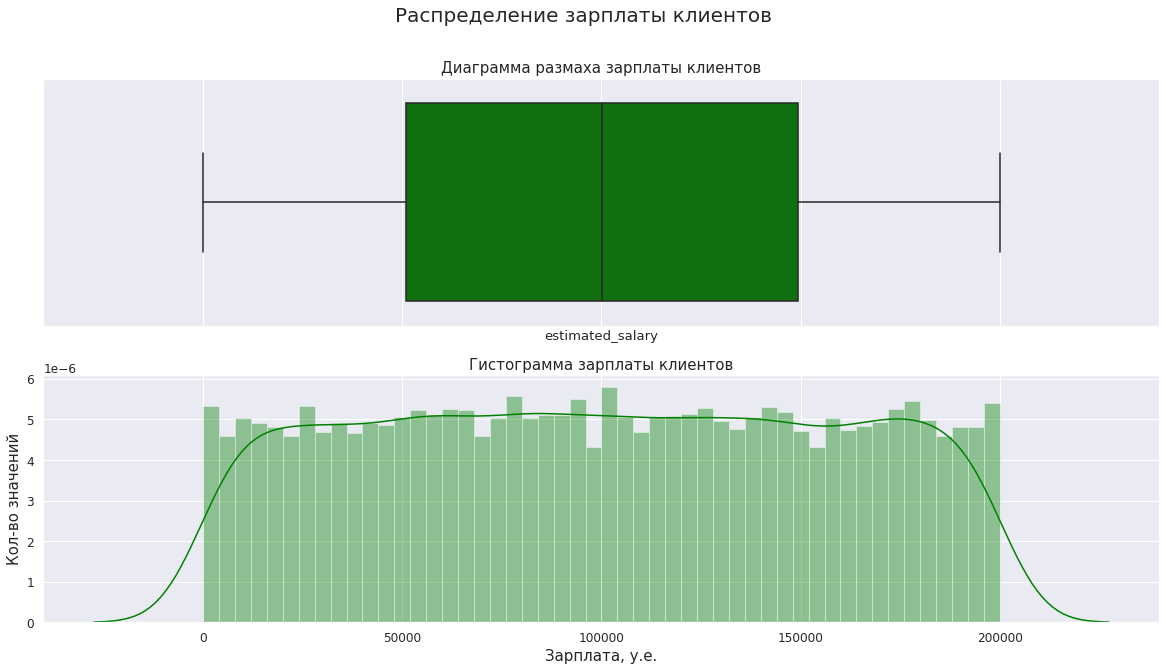

In [14]:
# зарплата
f, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))

ax[0].set_title('Диаграмма размаха зарплаты клиентов', size=15)
ax[1].set_title('Гистограмма зарплаты клиентов', size=15)

sns.boxplot(bank_data['estimated_salary'], color='green', ax=ax[0])
sns.distplot(bank_data['estimated_salary'], bins=50, color='green', ax=ax[1])

plt.xlabel('Зарплата, у.е.', size=15)
plt.ylabel('Кол-во значений', size=15);
plt.suptitle("Распределение зарплаты клиентов", size=20);

<font size=2,5> Если не учитывать клиентов без значений баланса, то графики и баланса, и заработнгой платы распределёны практически равномерно.

<font size=2,5><b>Вывод:</b><br/>
На основании анализа можно составить усреднённый портрет клиента, характерные признаки такого клиента:
* средний кредитный скоринг - 650 баллов;
* возрастом 39 лет;
* имеет в собственности 5 объектов;
* баланс на счёте порядка 76,5 тыс. у.е.;
* пользователь в среднем двумя банковских продуктов;
* с зарплатой около 100 тыс. у.е.;<br/>
    
    
- женщин среди клиентов немного меньше, чем мужчин - распределение 45/55;
- кредитная карта есть у 71% клиентов;
- активных клиентов 52%;
- в отток уходит 20,4% клиентов (что не так уж и мало);
- половина клиентов из Ярославля и по четверти из Ростова Великого и Рыбинска.

## Портрет клиентов, склонных уходить из банка

<font size=2,5> Посмотрим на средние значения в двух группах - тех, кто ушёл и тех, кто остался:

In [15]:
bank_data.groupby('churn').mean()

,user_id,score,age,objects,balance,products,estimated_salary,gender,credit_card,loyalty,city_Ростов Великий,city_Рыбинск,city_Ярославль
churn,,,,,,,,,,,,,
0,"15,733,903.88",651.85,37.41,5.03,"72,744.91",1.54,"99,738.39",0.57,0.71,0.55,0.21,0.26,0.53
1,"15,732,787.96",645.35,44.84,4.93,"91,108.29",1.48,"101,465.68",0.44,0.70,0.36,0.40,0.20,0.40


<font size=2,5> В целом значимых различий в средних значениях числовых признаков  не заметном, за исключением показателя активности клиента, тут у ушедших клиентов он значительно меньше, чем у уставшихся 0,36 против 0,55.<br/>
    
Разделим признаки на бинарные и числовые и построим графики распределения признаков для ушедших и для оставшихся клиентов. 

### Графики распределения признаков

In [16]:
# список с бинарными признаками
binary = bank_data.columns.values[8:].tolist()
print(binary)

# список с числовыми признаками
numerical = bank_data.columns.values[1:7].tolist()
print(numerical)

['gender', 'credit_card', 'loyalty', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль']
['score', 'age', 'objects', 'balance', 'products', 'estimated_salary']


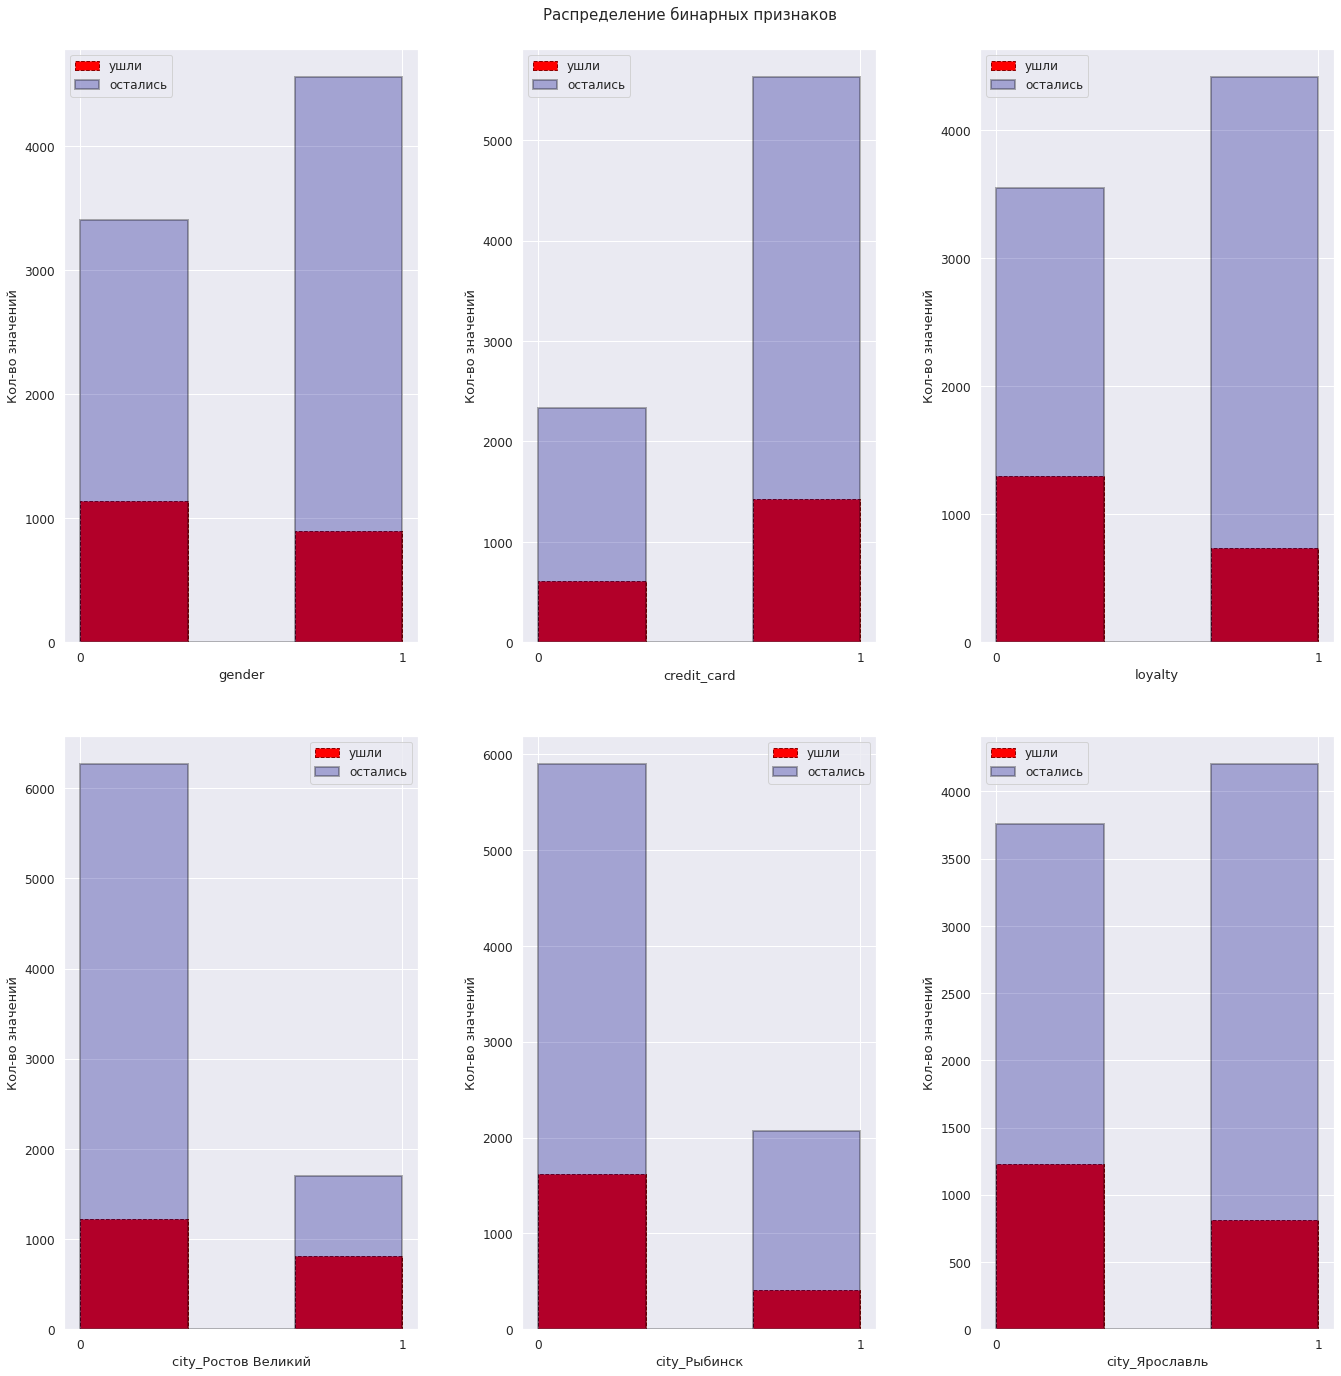

In [17]:
# графики для бинарных признаков

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение бинарных признаков', fontsize=15)
for value in binary:
    ax = axes_list.pop(0)
    # для ушедших
    sns.distplot(bank_data.query('churn == 1')[value], bins=3, ax=ax, kde=False, label='ушли',
                 hist_kws = {'color':'red', 'edgecolor':'darkred', 'linewidth':1, 'linestyle':'--', 'alpha':1}),
    # для оставшихся
    sns.distplot(bank_data.query('churn == 0')[value], bins=3, ax=ax, kde=False, label='остались',
                 hist_kws = {'color':'darkblue', 'edgecolor':'black', 'linewidth':2, 'linestyle':'-', 'alpha':0.3})
    ax.set_xticks([0,1])
    ax.set_xlabel(value, fontsize=13)
    ax.set_ylabel('Кол-во значений', fontsize=13)
    ax.legend();

<font size=2,5><u>По бинарным признакам можно сделать следующие выводы:</u>
* данным по женщинам меньше, чем по мужчинам и уходит их большая часть, в сравнии с долей клиентом-мужчин;
* также доля ушедших пользователей выше у клиентов без кредитной карты;
* из неактивных клиентов тоже уходит более ощутимая доля, в сравнении с активными клиентами;
* по городам же самый большой отток клиентов в Ростове Великом, доля ушедших значительно больше, в сравнении с  поведением клиентов в Рыбинске и Ярославле.<br/>
    
Построим графики для остальных признаков:

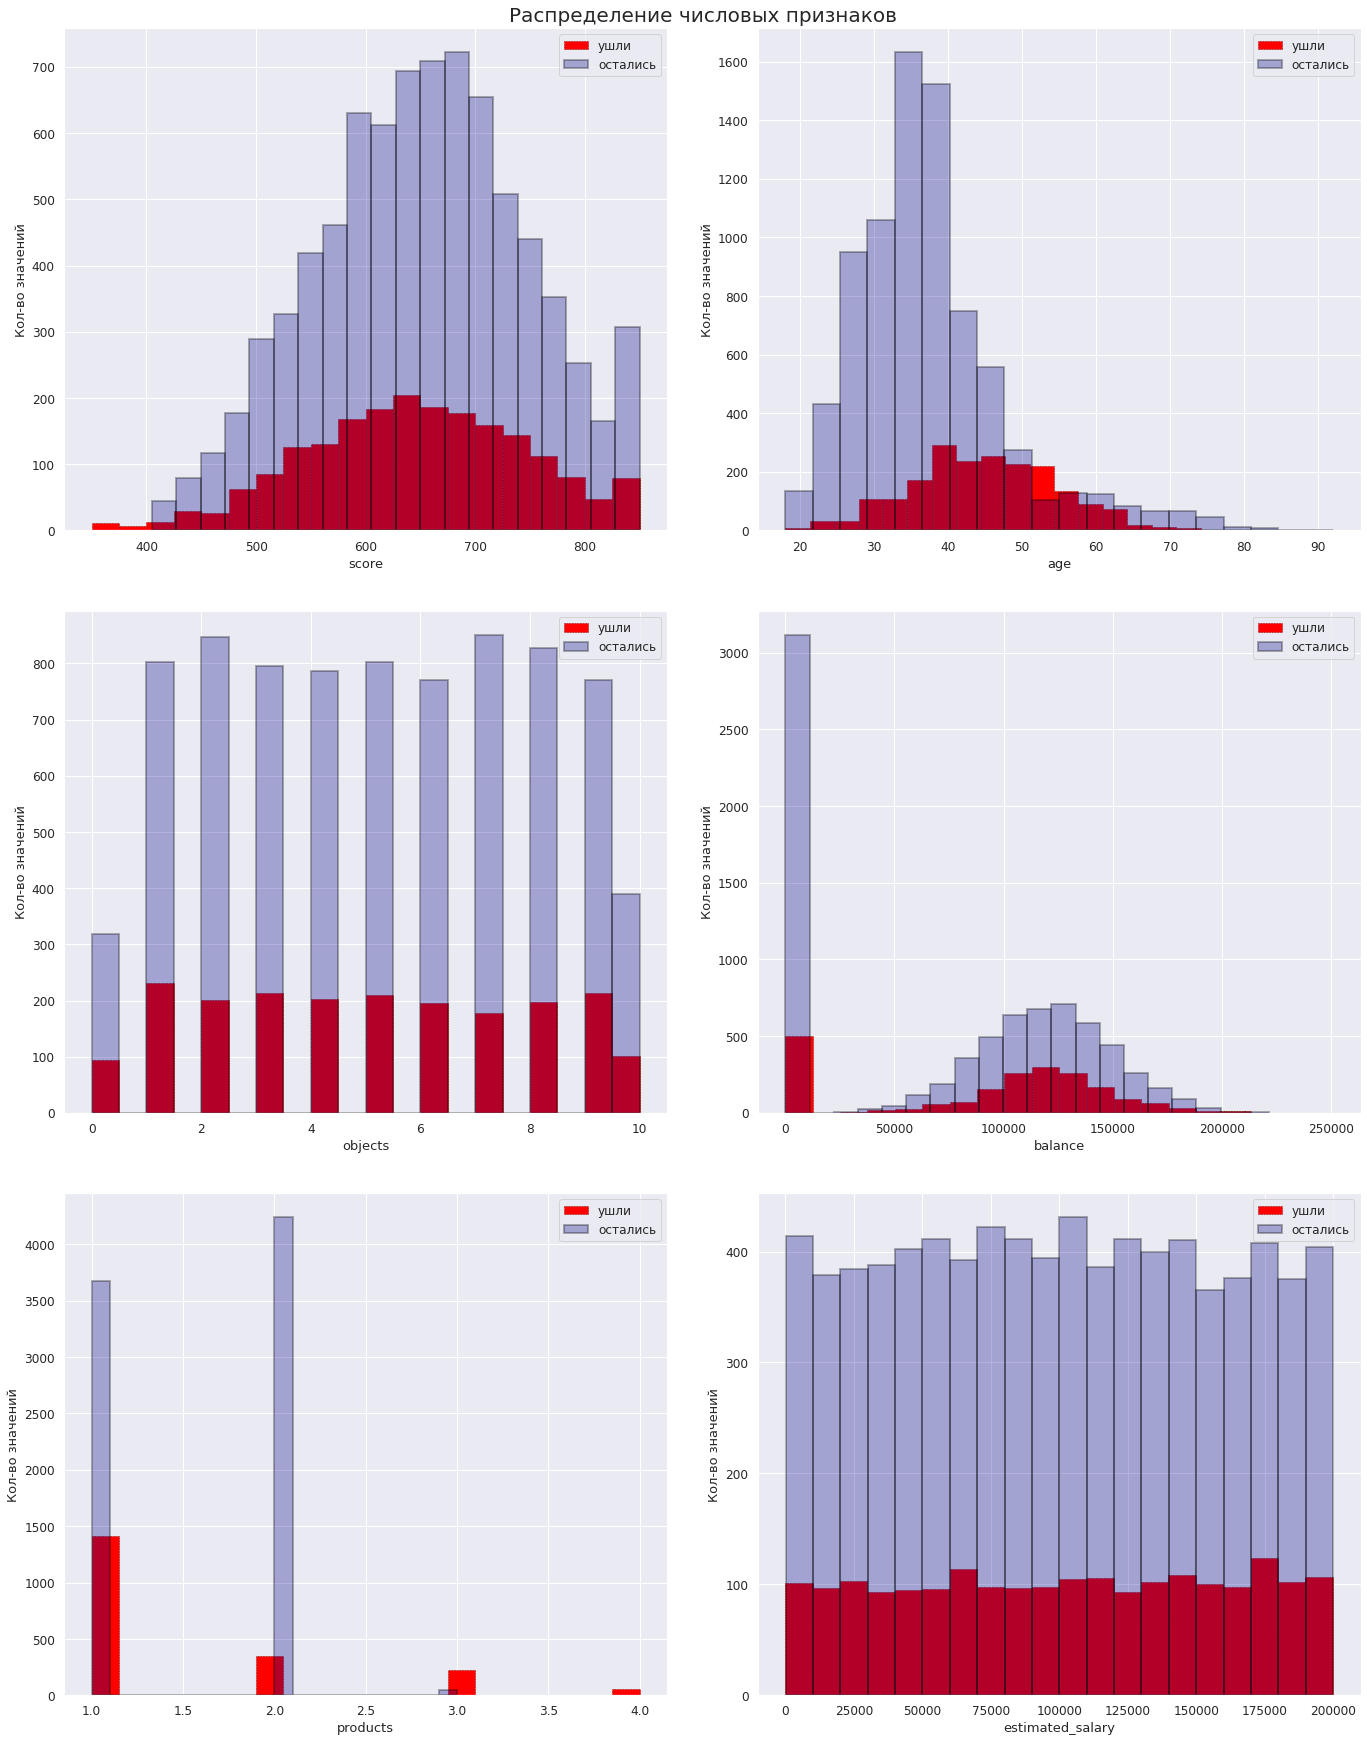

In [18]:
# графики для числовых признаков

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,25))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=4.0)
fig.suptitle('Распределение числовых признаков', fontsize=20)
for value in numerical:
    ax = axes_list.pop(0)
    # для ушедших
    sns.distplot(bank_data.query('churn == 1')[value], bins=20, ax=ax, kde=False, label='ушли',
                 hist_kws = {'color':'red', 'edgecolor':'darkred', 'linewidth':.5, 'linestyle':'--', 'alpha':1}),
    # для оставшихся
    sns.distplot(bank_data.query('churn == 0')[value], bins=20, ax=ax, kde=False, label='остались',
                 hist_kws = {'color':'darkblue', 'edgecolor':'black', 'linewidth':2, 'linestyle':'-', 'alpha':0.3})
    #ax.set_xticks([0,1])
    ax.set_xlabel(value, fontsize=13)
    ax.set_ylabel('Кол-во значений', fontsize=13)
    ax.legend();

<font size=2,5><u>По числовым признакам выводы  следующие:</u>
* кредитный скоринг - графики похоже, за исключением того, что клиенты с очень низким рейтингом все уходят в отток, что впрочем не удивительно, низкий рейтинг доверия не вызывает и маловероятно, что таким клиентам предлагают выгодные условия, которые бы их сделали постоянныим клиентами;
* сильный отток у клиентов в возрасте больше 45 лет, очень большой отток на отрезке 50...60 лет, увы, но нельзя отрицать, что тут не последнюю роль играет средняя продолжительность жизни в России и как следствие смертность, в "хвосте" клиентов после 60 лет отток не так велик, т.к. и клиентов таких немного и всё-таки это уже не тот возраст, когда люди задумываются о смене банка и поиске более выгодных условий обслуживания;
* по объектам в собственности каких-то особенностей выявить нельзя, доли ттока пропорциональны;
* то же самое можно сказать и о балансе клиентов, маловероятно что баланс счета клиентов как-то связан с их желанием перестать пользоваться услугами банка;
* а вот по количеству продуктов, которыми пользуется клиент, такое уже можно сказать: уходит больше трети клиентов с одним продуктом, большая доля клиентов с тремя продуктами и все клиенты с 4 продуктами;
* по зарплате клиентов графики пропорциональны, не каких-то сильно выделяющихся значений. 

### Матрица корреляций

<font size=2,5> Для того, чтобы составить более точный портрет клиента посмотрим на корреляцию признаков у клиентов в оттоке и оставшихся:

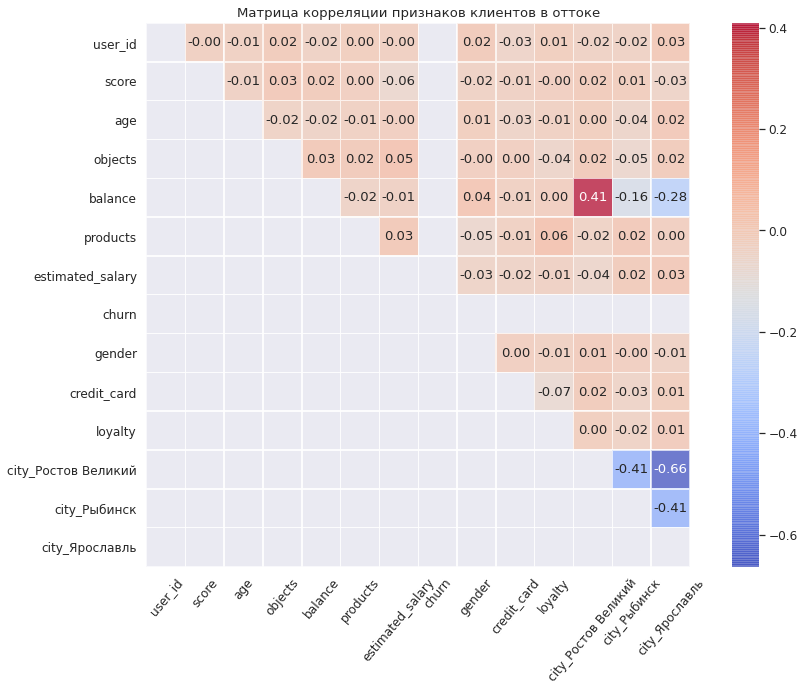

In [19]:
# для ушедших клиентов
corr_mtrx = bank_data.query('churn == 1').corr()
mask = np.tril(np.ones_like(corr_mtrx, dtype=bool))

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_mtrx, mask=mask, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm", square=True, alpha=.7)
plt.xticks(rotation=50)
plt.title('Матрица корреляции признаков клиентов в оттоке');

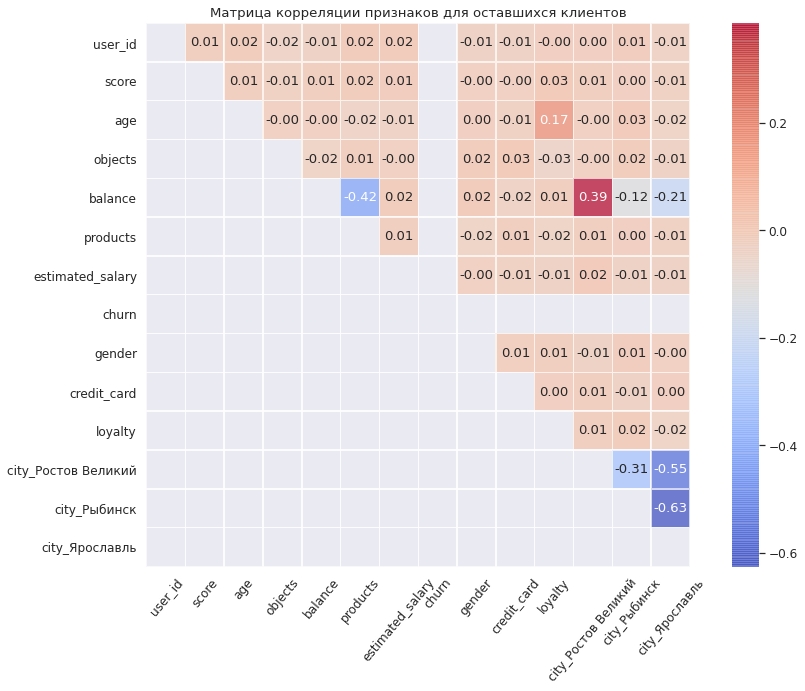

In [20]:
# для оставшихся клиентов
corr_mtrx = bank_data.query('churn == 0').corr()
mask = np.tril(np.ones_like(corr_mtrx, dtype=bool))

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_mtrx, mask=mask, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm", square=True, alpha=.7)
plt.xticks(rotation=50)
plt.title('Матрица корреляции признаков для оставшихся клиентов');

<font size=2,5> Каких-то сильных корреляци между признаками нет.<br/>
* У клиентов в оттоке сильная положительная корреляция между балансом и г.Ростовом Великим и отрицательная у баланса с Рыбинском и Ярославлем, что мы ранее уже видели на графиках, в остальном же показатели корреляции низкие, самое высокое значение - 0,06 у количества продуктов и активностью клиента. На корреляции баланса с Ростовом Великим, как в прочем и с остальными признаками, мы не можем дать однозначного ответа, т.к. изначально у нас очень большой процент пропусков в значениях баланса - 36%.
* У оставшихся клиентов также не акцентируем внимание на корреляции баланса с остальными признаками, самая сильная положительная связь - 0,17 у возраста с активностью, корреляция же остальных признаков также как и в случае с клиентами в оттоке, невелика.<br/>
    
Посмотрим на коррляцию признаков по всем данным сразу, возможно есть связь признаков напрямую с показетел оттока `churn`.

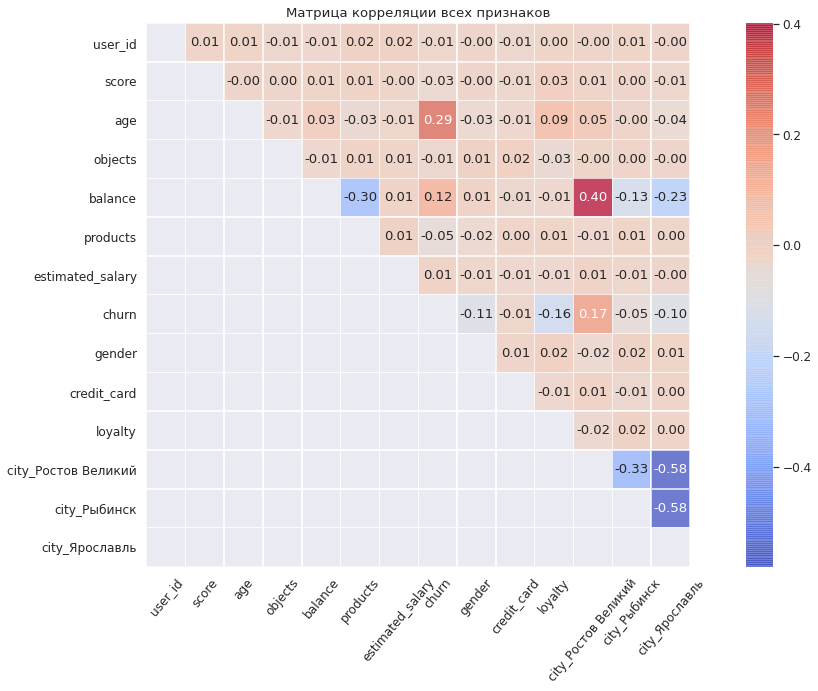

In [21]:
corr_mtrx = bank_data.corr()
mask = np.tril(np.ones_like(corr_mtrx, dtype=bool))

f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_mtrx, mask=mask, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm", square=True, alpha=.7)
plt.xticks(rotation=50)
plt.title('Матрица корреляции всех признаков');

<font size=2,5> У целевого признака `churn` сильная положительная только с возрастом - 0,29, с Ростов Великим - 0,17 и отрицательная с полом - -0,11, и активностью - -0,16.
    
<b>Вывод:</b><br/>
Каких-то ярких, выдающихся признаков, по которым бы можно было спрогнозировать отток клиента не выявлено, на основании имеющихся данных клиента, который с большей вероятностью уйдёт в отток, можно охарактеризовать следующим образом:
* это будет не самый активный клиент, скорее всего в возрасте за 40 лет;
* значение кредитного скоринга будет низкое (в красной зоне);
* пользоваться такой клиент будет скорее всего одним продуктом, но также возможна и обратная ситуация, что клиент будет иметь 3 или 4 банковских продукта;
* также велика вероятность, что это будет клиент из г. Ростов Великий.<br/>
    
Попробуем ещё немного лучше составить портрет клиента в оттоке, проведя кластеризацию клиентов.

### Кластеризация клиентов

Удалим из датасета данные о клиентах без значений баланса, т.к. процент пропусков велик (36%), фиктивная переменная или нулевые значения взамен пропущенных в любом случае приведут к искажению результатов. Также стоит удалить столбец `user_id`, числовые значения которого также могут сильно исказить результаты.

In [22]:
# создаём чистый датасет
bank_data_cluster = bank_data.query('balance != -1').drop('user_id', axis=1)
bank_data_cluster.head()

,score,age,objects,balance,products,estimated_salary,churn,gender,credit_card,loyalty,city_Ростов Великий,city_Рыбинск,city_Ярославль
1,608,41,1,"83,807.86",1,"112,542.58",0,0,0,1,0,1,0
2,502,42,8,"159,660.80",3,"113,931.57",1,0,1,0,0,0,1
4,850,43,2,"125,510.82",1,"79,084.10",0,0,1,1,0,1,0
5,645,44,8,"113,755.78",2,"149,756.71",1,1,1,0,0,1,0
7,376,29,4,"115,046.74",4,"119,346.88",1,0,1,0,1,0,0


#### Дендрограмма

<font size=2,5>Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.<br/>

In [23]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(bank_data_cluster)

# сохраняем таблицу связей
linked = linkage(X_sc, method = 'ward')
linked

array([[8.30000000e+01, 4.26600000e+03, 1.27930712e-01, 2.00000000e+00],
       [2.14800000e+03, 2.48900000e+03, 1.73998837e-01, 2.00000000e+00],
       [3.27300000e+03, 5.16200000e+03, 1.94049954e-01, 2.00000000e+00],
       ...,
       [1.27570000e+04, 1.27590000e+04, 8.51219017e+01, 2.50600000e+03],
       [1.27560000e+04, 1.27610000e+04, 1.32010114e+02, 3.87700000e+03],
       [1.27620000e+04, 1.27630000e+04, 1.41069043e+02, 6.38300000e+03]])

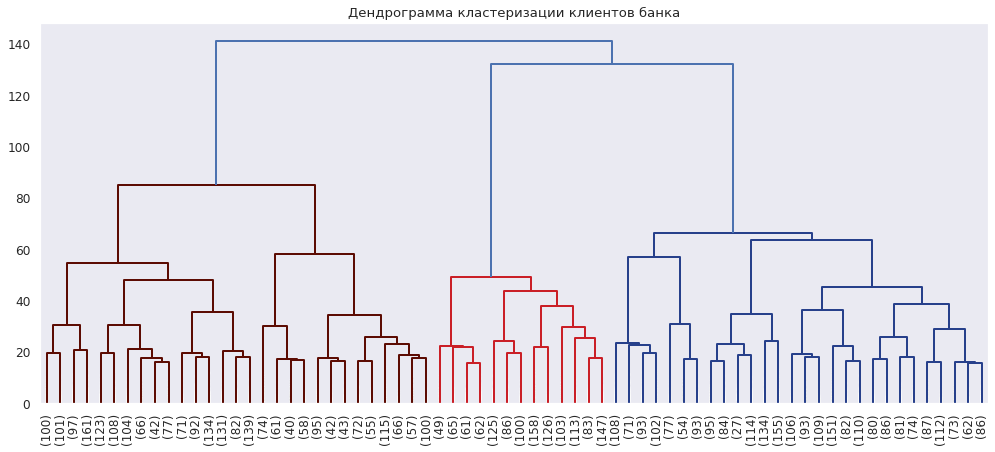

CPU times: user 23.2 s, sys: 432 ms, total: 23.7 s
Wall time: 24.2 s


In [24]:
%%time

# строим дендрограмму

hierarchy.set_link_color_palette(['#5c0c03', '#ca1f27', '#27408b', '#8430c8', '#555e31'])

sns.set_style("dark")

plt.figure(figsize=(17, 7))
with plt.rc_context({'lines.linewidth': 2.0}):
    dendrogram(linked,
               leaf_font_size=12,
               orientation='top',
               truncate_mode='lastp',
               p=70,
               show_contracted=True)
plt.title('Дендрограмма кластеризации клиентов банка')
#plt.xticks([])
hierarchy.set_link_color_palette(None)
plt.show()

<font size=2,5> Визуально хочется выделить 4 или даже 5 кластеров. Примем <b><i>n=4</i></b>

In [25]:
 # задаём число кластеров, равное 4
km = KMeans(n_clusters = 4, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc)
labels

array([1, 3, 1, ..., 3, 2, 3], dtype=int32)

In [26]:
# сохраняем метки кластера в исходный датасет
bank_data_cluster['cluster'] = labels

# выводим статистику по средним значениям наших признаков с группировкой по кластерам
bank_data_cluster.groupby('cluster').agg('mean').T

cluster,0,1,2,3
score,653.16,651.00,647.28,651.13
age,37.24,39.26,45.34,38.46
objects,5.01,4.98,5.01,4.95
balance,"119,438.46","119,814.99","120,130.46","119,990.95"
products,1.55,1.30,1.49,1.29
estimated_salary,"102,463.76","100,127.28","98,577.69","100,555.92"
churn,0.00,0.20,1.00,0.18
gender,0.56,0.57,0.44,0.56
credit_card,0.72,0.68,0.71,0.69
loyalty,0.56,0.55,0.36,0.51


<font size=2,5> В целом можно сказать, что кластеризация похоже что в первую очередь ориентировалась на города, а не на другие признаки.<br/>
Есть два кластера с небольшим оттоком, кластер полностью из оставшихся клиентов и также <i>кластер полностью состоящих из ушедших клиентов</i> - <b>№ 2</b>, для которого характерно следующее:
- самое низкое значение активности клиентов - 0,36;
- практически все клиенты из Ростова Великого - 0,98, оставшаяся доля клиентов из Ярославля.
    
Построим графики распределения признаков для кластера полностью состоящего из клиентов в оттоке.

#### Графики распределения признаков для клиентов в оттоке.

<font size=2,5> Выделяем таких клиентов в отдельный датасет.

In [27]:
churn_client = bank_data_cluster.query('cluster == 2').drop(columns=['churn', 'cluster'])
churn_client.head()

,score,age,objects,balance,products,estimated_salary,gender,credit_card,loyalty,city_Ростов Великий,city_Рыбинск,city_Ярославль
7,376,29,4,"115,046.74",4,"119,346.88",0,1,0,1,0,0
16,653,58,1,"132,602.88",1,"5,097.67",1,1,0,1,0,0
46,829,27,9,"112,045.67",1,"119,708.21",0,1,1,1,0,0
47,637,39,9,"137,843.80",1,"117,622.80",0,1,1,1,0,0
53,655,41,8,"125,561.97",1,"164,040.94",1,0,0,1,0,0


<font size=2,5> Строим графики распределения признаков, для городов графики не строим, т.к. практически целиком все такие клиенты из Ростова Великого

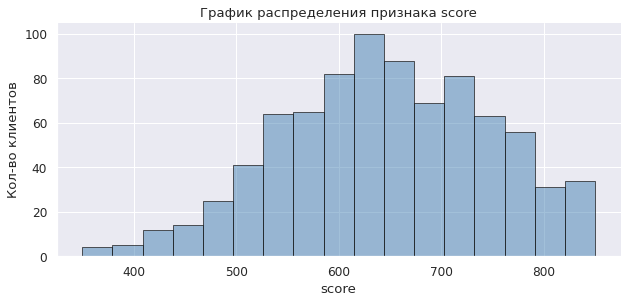

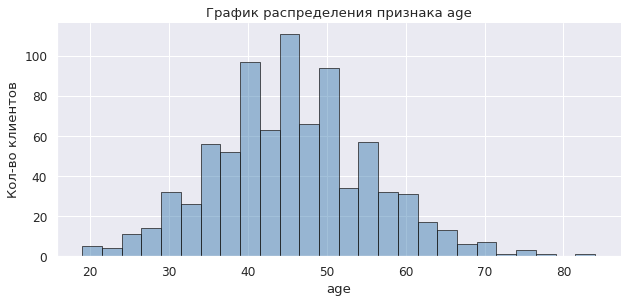

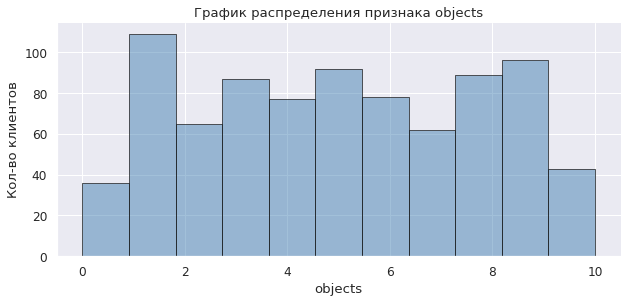

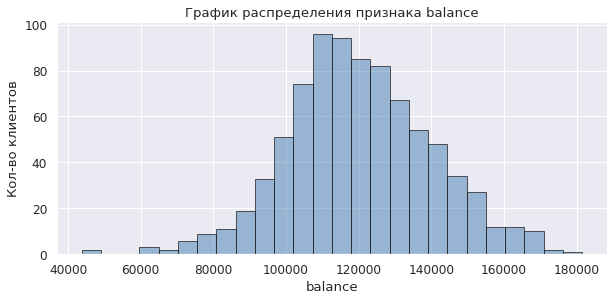

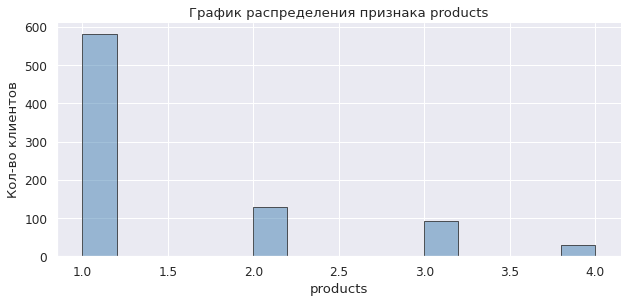

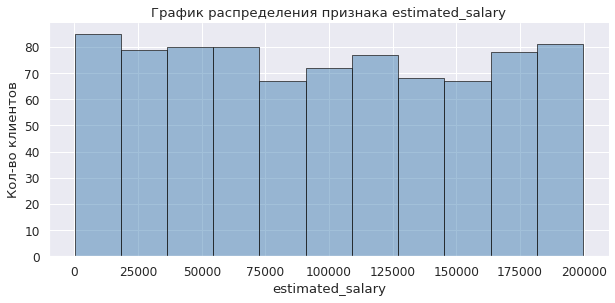

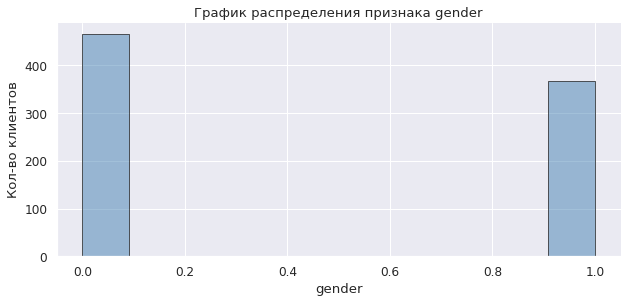

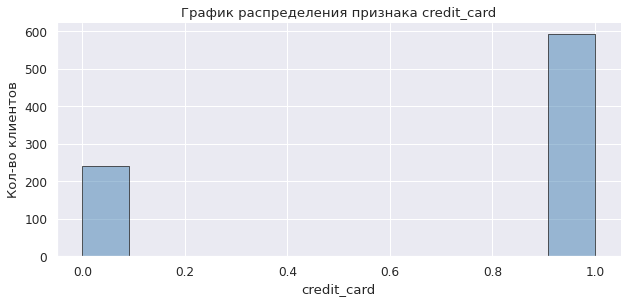

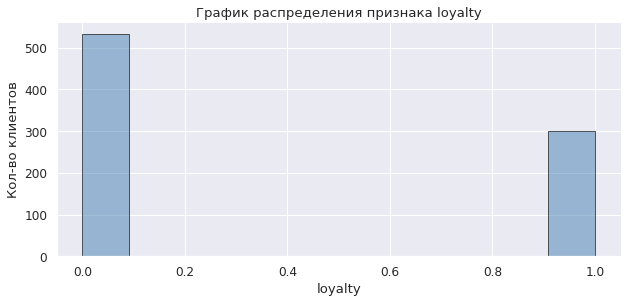

In [28]:
sns.set_style("darkgrid")

# список с признаками
values = churn_client.columns.values[:9].tolist()

for value in values:
    g = sns.displot(churn_client, x=churn_client[value],
                    color="steelblue", edgecolor="k", linewidth=.7,
                    alpha=.5, kind='hist', multiple='stack')
    plt.title(f'График распределения признака {value}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel(value)
    #plt.xticks([0, 1])
    g.fig.set_figwidth(10)
    g.fig.set_figheight(4);

<font size=2,5> <i>По результатам кластеризации значения признаков клиента в оттоке следующие:</i>
* средний возраст 45 лет;
* в среднем 5 объектов в собственности;
* и 1,5 банковских продукта в использовании;
* 71% клиентов владеет кредитной картой;
* 36% активных клиентов
* Большая часть проживает в г. Ростов Великий.<br/>
    
Сравним, насколько сильно отличаются показатели кластеризации от расчета средних значений при простом разделении клиентов на две группы:

In [29]:
# таблица со средними значениями признаков пользователей в оттоке по исходным данным
churn_start = bank_data.groupby('churn').mean().query('churn == 1').drop('user_id', axis=1).T.reset_index()
churn_start = churn_start.rename(columns = {'index':'feature', 1:'mean_by_start'})
churn_start

churn,feature,mean_by_start
0,score,645.35
1,age,44.84
2,objects,4.93
3,balance,"91,108.29"
4,products,1.48
5,estimated_salary,"101,465.68"
6,gender,0.44
7,credit_card,0.70
8,loyalty,0.36
9,city_Ростов Великий,0.40


In [30]:
# таблица со средними значениями признаков пользователей в оттоке по кластеризации
churn_cluster = pd.DataFrame(churn_client.agg('mean')).reset_index()
churn_cluster = churn_cluster.rename(columns = {'index':'feature', 0:'mean_by_clustering'})
churn_cluster

,feature,mean_by_clustering
0,score,647.28
1,age,45.34
2,objects,5.01
3,balance,"120,130.46"
4,products,1.49
5,estimated_salary,"98,577.69"
6,gender,0.44
7,credit_card,0.71
8,loyalty,0.36
9,city_Ростов Великий,0.98


In [31]:
# сводная таблица
churn_merge = pd.merge(churn_start, churn_cluster) 
churn_merge

# добавляем расчёт разницы значений
churn_merge['difference, %'] = (1 - churn_merge['mean_by_start'] / churn_merge['mean_by_clustering']) * 100
churn_merge.sort_values(by=['feature'])

,feature,mean_by_start,mean_by_clustering,"difference, %"
1,age,44.84,45.34,1.10
3,balance,"91,108.29","120,130.46",24.16
9,city_Ростов Великий,0.40,0.98,59.21
10,city_Рыбинск,0.20,0.00,-inf
11,city_Ярославль,0.40,0.02,"-1,850.79"
7,credit_card,0.70,0.71,1.68
5,estimated_salary,"101,465.68","98,577.69",-2.93
6,gender,0.44,0.44,0.09
8,loyalty,0.36,0.36,0.02
2,objects,4.93,5.01,1.49


<font size=2,5> Сравнение средних значений, полученных при простом разделении пользователей на тех кто уушел в отток и при выделении таких пользователей при кластеризаци не показывает существенных различий, результаты те же самые, различия только в балансе, т.к. при кластеризации мы исключили пользователей у которых отсутсвуют данные о балансе, а у пользователей просто сгруппированых по оттоку изначально присутсвуют данные с фиктивной переменной <b><i>-1</b></i>, которые также искажают результаты.
Также отличаются данные о распределении клиентов по городам.<br/>

### Вывод

<font size=2,5> Обобщая данные полученные при кластеризации и при общем анализе клиентов ушедших в отток, портрет клиента, предрасположенного к оттоку выглядит следующим образом:<br/>
* средний возраст 45 лет;
* проживает с большой долей вероятности в Ростове Великом или Ярославле - 40%, вероятность роживания в Рыбинске - 20%;
* имеет кредитную карту ~70%;
* скорее это женщина - 55%, а не мужчина - 45%;
* низкая активность, активных клиентов в оттоке 36%;
* в собственности имеет в среднем 5 объектов;
* оформляет 3-4 банковских продукта;
* среднее значение кредитного рейтинга в [жёлтой зоне](https://i.ytimg.com/vi/JGrNphmGhH8/maxresdefault.jpg), средний скоринг - 645 баллов.

## Проверка статистических гипотез

<font size=2,5> По условиям задания нам нужно проверить гипотезу о различии дохода между теми клиентами, которые ушли и теми, которые остались. Во время исследования мы выяснили, что в отток уходят менее активные клиенты, проверим гипотезу о различии активности между теми клиентами, которые ушли и теми, которые остались.

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

<font size=2,5> <b>Сформулируем гипотезы:</b><br/>
<b>Н0</b> - доход клиентов, ушедших в отток <u>не отличается</u> от дохода клиентов, оставшихся в банке.<br/>
<b>Н1</b> - доход клиентов, ушедших в отток <u>отличается</u> от дохода клиентов, оставшихся в банке.<br/>
критический уровень статистической значимости зададим в 5%.
    
перед проверкой гипотезы сравним размеры выборок:

In [32]:
# создаём выборки клиентов
churn = bank_data.query('churn == 1')['estimated_salary']
no_churn = bank_data.query('churn == 0')['estimated_salary']

print('Клиентов в оттоке:', len(churn))
print('Оставшихся клиентов:', len(no_churn))

Клиентов в оттоке: 2037
Оставшихся клиентов: 7963


<font size=2,5> Размеры выборок различны и сильно, но с этим мы не можем ничего сделать.

In [33]:
alpha = .05

results = stats.ttest_ind(churn, no_churn)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось опровергнуть нулевую гипотезу")

P-value: 0.22644042802223346
Не получилось опровергнуть нулевую гипотезу


<font size=2,5> Нулевую гипотезу отвергнуть не удалось, <b>доход клиентов, ушедших в отток не отличается от дохода клиентов, оставшихся в банке.</b><br/>
    
Посмотрим на ср.значения дохода у групп:

In [34]:
print('Средний доход клиентов в оттоке - {:.2f} руб.'.format(churn.mean()))
print('Средний доход оставшихся клиентов - {:.2f} руб.'.format(no_churn.mean()))
print('-'*10*5)
print('Разница - {0:.2%}'.format(churn.mean()/no_churn.mean() -1))


Средний доход клиентов в оттоке - 101465.68 руб.
Средний доход оставшихся клиентов - 99738.39 руб.
--------------------------------------------------
Разница - 1.73%


<font size=2,5> Разница средних значений меньше 2%

### Проверка гипотезы различия активности между теми клиентами, которые ушли и теми, которые остались.

<font size=2,5> <b>Сформулируем гипотезы:</b><br/>
<b>Н0</b> - % (кол-во) неактивных клиентов, ушедших в отток <u>не отличается</u> от % (кол-во) неактивных клиентов, оставшихся в банке.<br/>
<b>Н1</b> - % (кол-во) неактивных клиентов, ушедших в отток <u>отличается</u> от % (кол-во) неактивных клиентов, оставшихся в банке.<br/>
критический уровень статистической значимости зададим в 5%.
    
перед проверкой гипотезы сравним размеры выборок:

In [35]:
# оставшиеся клиенты
clients = bank_data.query('churn == 0').groupby('loyalty').agg({'user_id':'count'})['user_id']
clients

loyalty
0    3547
1    4416
Name: user_id, dtype: int64

In [36]:
# клиенты в оттоке
churn_clients = bank_data.query('churn == 1').groupby('loyalty').agg({'user_id':'count'})['user_id']
churn_clients

loyalty
0    1302
1     735
Name: user_id, dtype: int64

In [37]:
alpha = .05

results = stats.ttest_ind(clients, churn_clients)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось опровергнуть нулевую гипотезу")

P-value: 0.029316986848712062
Отвергаем нулевую гипотезу


<font size=2,5> Нулевую гипотезу отвергаем, <b>% (кол-во) неактивных клиентов, ушедших в отток отличается от % (кол-во) неактивных клиентов, оставшихся в банке.</b><br/>
    
Посмотрим на значения:

In [38]:
print('Кол-во неактивных клиентов от общего числа клиентов - ', clients[0])
print('Доля от активных клиентов - {0:.2%}'.format(1 - clients[0] / clients[1]))
print('-'*10*5)
print('Кол-во неактивных клиентов в оттоке - ', churn_clients[0])
print('Доля от активных клиентов - {0:.2%}'.format(1 - churn_clients[0] / churn_clients[1]))

Кол-во неактивных клиентов от общего числа клиентов -  3547
Доля от активных клиентов - 19.68%
--------------------------------------------------
Кол-во неактивных клиентов в оттоке -  1302
Доля от активных клиентов - -77.14%


<font size=2,5> Разница между активными и неактивными оставшимися клиентами 19,7% в пользу активных клиентов, их среди оставшихся больше, тогда как для клиентов в оттоке разница составляет 77,2% в пользу неактивных клиентов.

## Общий вывод

<font size=2,5><i><b>В проекте был проведён анализ оттока клиентов банка.</b></i><br/>
    
* Перед проведением анализа выполнена небольшая предобработка данных, исправили названия столбцов, заполнили пропуски в столбце с данными о балансе на счёте фиктивной переменной, поскольку процент пропусков оказался слишком велик - 36%. Также заменили категоральные значения в столбцах с информацией о <i>поле</i> и <i>городе</i> на числовые, в дальнейшем это упростит кластеризацию клиентов банка.<br/>
    
<i>Стоит отметить, что среди клиентов с отсутствующими значениями баланса нет жителей из г. Ростов Великий, все такие клиенты из Рыбинска и Ярославля. Похоже, что мы имеем дело с какой-то технической ошибкой, которая появилась не только на этапе сбора данных, а возможно ещё раньше и проблема где-то в банковском ПО. Об этом стоит сообщить специалистам/коллегам, ответственным за подготовку данных.</i>
    
<hr style="border-color: darkblue;">
    
<i><b>На этапе исследовательского анализ составлен усреднённый портрет клиента банка, значения признаков следующие:</b></i><br/>
* средний кредитный рейтинг - 650 баллов;
* возраст 39 лет;
* имеет в собственности 5 объектов;
* баланс на счёте порядка 76,5 тыс. у.е.;
* пользуется в среднем двумя банковскими продуктами;
* зарплата около 100 тыс. у.е.;<br/>
     
    
- женщин среди клиентов немного меньше, чем мужчин - распределение 45/55;
- кредитная карта есть у 71% клиентов;
- активных клиентов 52%;
- в отток уходит 20,4% клиентов (что не так уж и мало);
- половина клиентов из Ярославля и по четверти из Ростова Великого и Рыбинска.<br/>
    
<hr style="border-color: darkblue;">

<i><b>Отдельно был составлен портрет клиентов, склонных уходить из банка</b></i><br/>
Рассмотрены признаки, представленные в датасете, их корреляция, а также с целью поиска неочевидных связей между признаками была проведена кластеризация клиентов. Признаки клиента, предрасположенного к оттоку выглядит следующим образом:<br/>
    
* средний возраст 45 лет;
* проживает с большое долей вероятности в Ростове Великом или Ярославле - 40%, вероятность проживания в Рыбинске - 20%;
* имеет кредитную карту ~70%;
* скорее это женщина - 55%, а не мужчина - 45%;
* низкая активность, активных клиентов в оттоке 36%;
* в собственности имеет в среднем 5 объектов;
* оформляет в 3-4 продукта;
* кредитный рейтинг почти не отличается от такового от среднего значения для всех клиентов и составляет - 645 баллов.<br/>
    
<hr style="border-color: darkblue;">

<i><b>Выполнена проверка гипотез:</b></i><br/>

* Доход клиента не влияет на факт оттока, проверка гипотезы не выявила статистически значимых различий между значениями дохода у оставшихся клиентов и у ушедших.
* А вот кол-во (%) активных клиентов в оттоке отличается от таких значений для оставшихся клиентов, разница между значениями статистически значима.

## Рекомендации

<font size=2,5><b>На основании проведённого анализа сложно давать уверенные рекомендации по удержанию клиентов, но если в целом, то стоит обратить внимание на следующие моменты:</b>
    
1. Акцент на возрастных клиентов (старше 40), поскольку как правило это уже состоявшиеся люди со стабильным и хорошим заработком возможно стоит им предлагать индивидуальные инвестиционные предложения, а более возрастным клиентам пенсионные программы.<br/>
    
    
2. Поскольку более чем 2/3 ушедших имеют кредитную карту, предложение немного более выгодных условий кредитования, например увеличение льготного периода по карте, также заставит клиента задуматься прежде чем уйти к конкурентам.<br/>
      
    
3. Все клиенты, имеющие 3-4 банковских продукта попадают в отток, зная наверняка какими точно банковскими продуктами они пользуются, точно так же как и с кредитными картами таким лояльным клиентам можно попробюовать предложить "симбиоз" более выходных условий обслуживания.<br/>
    
    
4. Также стоит обратить внимание на такой момент, что процент пользователей в оттоке сильно выше в Ярославле и Ростове Великом, возможно стоит провести мониторинг работы сотрудников банка, маловероятно, что география может как-то повлиять на работу сайта или мобильного приложения, "треугольник" городов не расположен в каком-то труднодоступном регионе. А вот несоблюдение стандартов общения с клиентами может иметь негативный эффект. Либо провести мониторинг предложений конкурентов в этих городах, возможно для жителей этих городов у них есть выгодные предложения.